In [1]:
#%% Setup.

# Activate environment.
! . ~/env/bin/activate

# Install requirements.

! pip install --upgrade numpy torch scipy sklearn nibabel nilearn matplotlib

Requirement already up-to-date: numpy in /home/dcrowley/ARDENT_gpu_test/env/lib/python3.6/site-packages (1.16.4)
Requirement already up-to-date: torch in /home/dcrowley/ARDENT_gpu_test/env/lib/python3.6/site-packages (1.1.0)
Requirement already up-to-date: scipy in /home/dcrowley/ARDENT_gpu_test/env/lib/python3.6/site-packages (1.3.0)
Requirement already up-to-date: sklearn in /home/dcrowley/ARDENT_gpu_test/env/lib/python3.6/site-packages (0.0)
Requirement already up-to-date: nibabel in /home/dcrowley/ARDENT_gpu_test/env/lib/python3.6/site-packages (2.4.1)
Requirement already up-to-date: nilearn in /home/dcrowley/ARDENT_gpu_test/env/lib/python3.6/site-packages (0.5.2)
Requirement already up-to-date: matplotlib in /home/dcrowley/ARDENT_gpu_test/env/lib/python3.6/site-packages (3.1.0)


## Imports

In [2]:
#%% Imports.

import numpy as np
import ardent

import matplotlib
%matplotlib inline

/home/dcrowley/ARDENT_gpu_test/env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Prepare template and target

### Load template and target arrays from file.

Note: in this demo we use the Allen mouse brain atlas for the template, and thus the words 'atlas' and 'template' are effectively interchangable hereafter.

'atlas' is used in the code of this demo, whereas 'template' is used internally to ardent.

In [3]:
#%% Load template and target.

directory_path = '/home/dcrowley/image_lddmm_tensorflow/'
atlas_image_file_name = 'average_template_50.img'
target_image_file_name = '180517_Downsample.img'

atlas_file_name = directory_path + atlas_image_file_name
target_file_name = directory_path + target_image_file_name

atlas = ardent.load(atlas_file_name)
target = ardent.load(target_file_name)

### Preprocess template and target 

In [4]:
#%% Reform and normalize images.

atlas = ardent.basic_preprocessing(atlas)
target = ardent.basic_preprocessing(target)

# If you are wondering, the above does the same thing as below:
'''
# Normalize.
# Compute mean absolute deviation.
atlas_mean_absolute_deviation = np.mean(np.abs(atlas - np.median(atlas)))
target_mean_absolute_deviation = np.mean(np.abs(target - np.median(target)))
# Subtract mean.
atlas -= np.mean(atlas)
target -= np.mean(target)
# Divide by mean absolute deviation.
atlas /= atlas_mean_absolute_deviation
target /= target_mean_absolute_deviation

# Pad with zeros.
atlas = np.pad(atlas, pad_width=5, mode='constant', constant_values=0)
target = np.pad(target, pad_width=5, mode='constant', constant_values=0)
'''

"\n# Normalize.\n# Compute mean absolute deviation.\natlas_mean_absolute_deviation = np.mean(np.abs(atlas - np.median(atlas)))\ntarget_mean_absolute_deviation = np.mean(np.abs(target - np.median(target)))\n# Subtract mean.\natlas -= np.mean(atlas)\ntarget -= np.mean(target)\n# Divide by mean absolute deviation.\natlas /= atlas_mean_absolute_deviation\ntarget /= target_mean_absolute_deviation\n\n# Pad with zeros.\natlas = np.pad(atlas, pad_width=5, mode='constant', constant_values=0)\ntarget = np.pad(target, pad_width=5, mode='constant', constant_values=0)\n"

## Orient target to template

### Visualize images

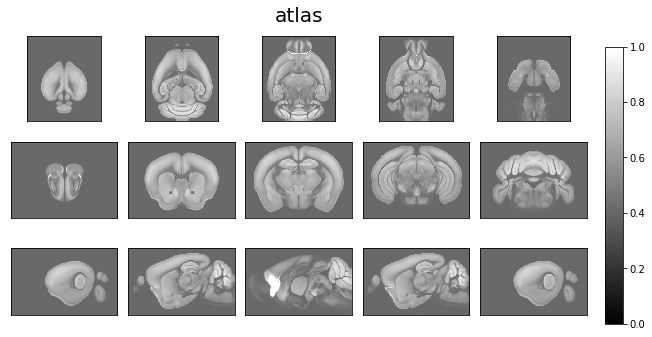

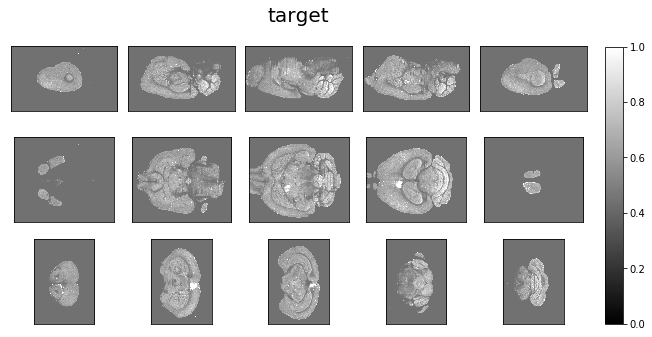

In [5]:
#%% Visualize images before registration.
# It is important to check that the images are oriented to one another 
# and do not require rotating or flipping.

ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(target, title='target', limit_mode='stdev')

### Reorient target and revisualize

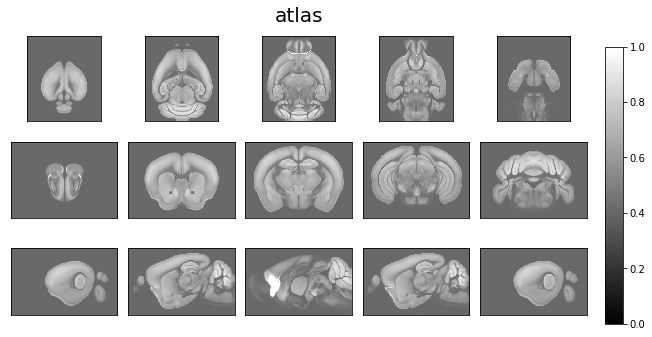

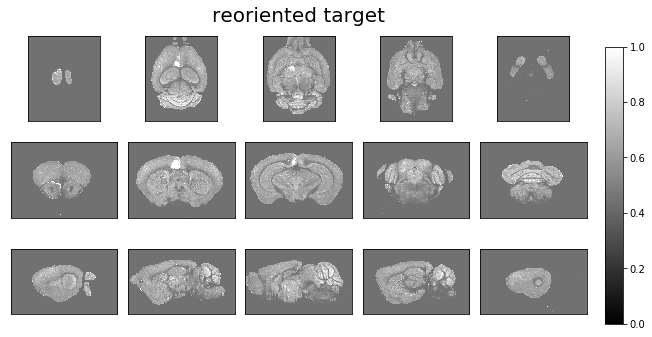

In [6]:
#%% Orient images.
# From looking at the two images we can see that they are not oriented.
# This must be corrected prior to performing the registration.

# Here we will orient the target to the template (atlas).
reoriented_target = np.copy(target)
reoriented_target = np.rot90(reoriented_target, axes=(1,2))
reoriented_target = np.rot90(reoriented_target, axes=(2,0))
# np.moveaxis does nothing when destination == source.
# reoriented_target = np.moveaxis(reoriented_target, source=[0,1,2], destination=[0,1,2])
reoriented_target = np.flip(reoriented_target, axis=0)
reoriented_target = np.flip(reoriented_target, axis=1)

# If we performed an odd number of inversions with the above lines, 
# we must perform a flip to correct for inverting the image. 
# The simplest flip is a sagittal flip, since that is the axis of innate symmetry in the brain.
# In this case, we can see from the atlas visualization that this is axis 2 (the last row).
# The above lines performed 2 inversions, so the following line is commented out.
# reoriented_target = np.flip(reoriented_target, axis=2)

# Verify proper orientation.
ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(reoriented_target, title='reoriented target', limit_mode='stdev')

### Use reoriented target

In [7]:
#%% Use reoriented target.
# Once we've finished orienting target, we use the result as target.
# A copy is taken to get a real array rather than a view.
target = reoriented_target.copy()

# Pad images to same shape.
atlas, target = ardent.lddmm.torch_lddmm_wrapper._pad_to_same_shape(atlas, target)

# Perform registration

In [8]:
#%% Perform registration.

# Instantiate Transform object.
transform = ardent.Transform()

transform.register(template=atlas, target=target, 
    sigmaR=1e6, eV=0.1, niter=5)


Current parameters:
>    a               = 2 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 5 (number of iterations)
>    epsilon         = 0.1 (gradient descent step size)
>    epsilonL        = 0 (gradient descent step size, affine)
>    epsilonT        = 0 (gradient descent step size, translation)
>    minbeta         = 1e-15 (smallest multiple of epsilon)
>    sigma           = 1.0 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 1000000.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 1 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CUDA_VISIBLE_

/home/dcrowley/ARDENT_gpu_test/ardent/ardent/lddmm/torch_lddmm_stable.py:564: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.It[ii][i] = torch.tensor(self.I[ii][:,:,:]).type(self.params['dtype']).cuda()


iter: 0, E = 16586394.0000, ER = 0.0000, EM = 16586394.0000, epd = 0.100000.
iter: 1, E= 16564784.000, ER= 0.000, EM= 16564784.000, epd= 0.100, time= 2.62.
iter: 2, E= 16543336.000, ER= 0.000, EM= 16543336.000, epd= 0.100, time= 2.62.
iter: 3, E= 16522044.000, ER= 0.000, EM= 16522044.000, epd= 0.100, time= 2.63.
iter: 4, E= 16500914.000, ER= 0.000, EM= 16500914.000, epd= 0.100, time= 2.63.


# Apply transformation

In [9]:
#%% Apply the transformation.
# The transformation is the result of the registration, and it can be applied to arbitrary images, 
# although presently they should be preprocessed as the atlas and target were.
# Here we will simply apply the transformation to both the atlas and target, 
# making them match up with each other.
# i.e. deformed_target should resemble atlas, and deformed_atlas should resemble target.

temp_directory_path = directory_path + 'DELETETHIS/'
deformed_atlas_file_name = temp_directory_path + 'deformed_atlas'
deformed_target_file_name = temp_directory_path + 'deformed_target'

deformed_atlas = transform.apply_transform(subject=atlas, deform_to='target', save_path=deformed_atlas_file_name)
deformed_target = transform.apply_transform(subject=target, deform_to='template', save_path=None)

ardent.save(deformed_target, deformed_target_file_name)

# Note: deformed_atlas is saved in the apply_transform call by providing a path for save_path.
# Note: deformed_target is saved after-the-fact with ardent.save(data, file_path).

# Visualize results

In [ ]:
#%% Visualize results.

ardent.heatslices(deformed_atlas, title='deformed_atlas', limit_mode='stdev')
ardent.heatslices(deformed_target, title='deformed_target', limit_mode='stdev')

# To simply visualize error we plot the difference between images.
ardent.heatslices(deformed_target - atlas, title='error in atlas space', limit_mode='stdev')
ardent.heatslices(target - deformed_atlas, title='error in target space', limit_mode='stdev')
ardent.heatslices(target - atlas, title='error before registration', limit_mode='stdev')

# Save the registration

In [10]:
transform_file_name = temp_directory_path + 'transform_file'

transform.save(transform_file_name)

# Load the registration

In [11]:
# Make a new Transform object.
loaded_transform = ardent.Transform()

# Load the attributes from the saved transform
loaded_transform.load(transform_file_name)

np.all(transform.phis == loaded_transform.phis)
np.all(transform.phiinvs == loaded_transform.phiinvs)
np.all(transform.Aphis == loaded_transform.Aphis)
np.all(transform.phiinvAinvs == loaded_transform.phiinvAinvs)
np.all(transform.affine == loaded_transform.affine)

KeyError: 'phiinvs is not a file in the archive'